# Notes on Constrained Optimization
## Analytical and numerical approaches

This notebook contains some interactive graphical examples and a simple sample numerical constrained optimization.  This notebook uses widgets from the `ipywidgets` library which will not be rendered in a static view. 

To keep thing uncluttered much of the code has been moved to a [code section](#Code-Section). To render and later figures and analysis run the code cells there first and then move through the cells below.

### Consumer's optimization problem:

$$\max_{x_0,x_1} U(x_0,x_1) $$

subject to a budget constraint

$$p x_0 + x_1 \leq I $$

where $p=\frac{p_{0}}{p_{1}}$

Let's make some parameter assumptions for the default examples and diagrams below.

Now define the utility function and budget constraint

For this Cobb-Douglas we can get easy analytical solutions that give us the Marshallian demands:

$$x_0^* = \alpha \cdot \frac{I}{p}$$

$$x_1^* = (1-\alpha) \cdot I$$

Here is a function that given prices, income and share parameter, returns a vector of Marshallian demands $[x_0^*, x_1^*]$, along with the maximized level of utility $Ux_0^*, x_1^*)$.

Cobb-Douglas utility:  $U(c_0,c_1) = c_0^a \cdot c_1^{1-a}$

In [1]:
import sys
sys.path.insert(0,'../intro')
from cd import *


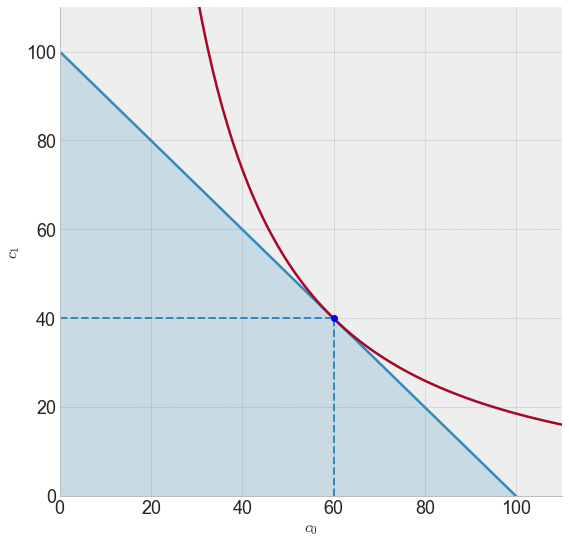

In [2]:
consume_plot(p=1, I=100, a = 0.6)

In the next cell control plot parameters with sliders (will only display if running with live kernel)

In [3]:
interact(consume_plot, p=(0.5,2,0.1), I=(50,150,10), a=(0.1,0.9,0.1));

interactive(children=(FloatSlider(value=1.2000000000000002, description='p', max=2.0, min=0.5), IntSlider(valu…

## The 'no-arbitrage' argument 
Move the slider to move the consumption point along the budget line. Keep adjusting until we reach the highest indifference curve at a tangency point.

In [4]:
alpha = 0.6
p = 1
I = 100

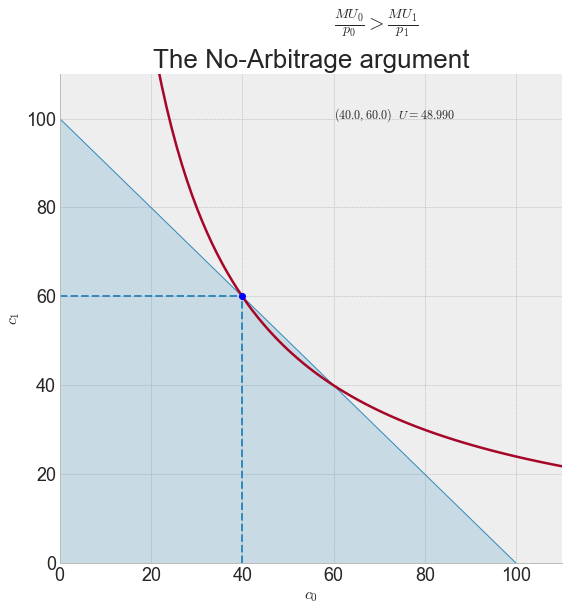

In [5]:
arb_plot(c0g=40, I=100, p=1)

In the next cell control plot parameters with sliders (will only display if running with live kernel)

In [6]:
interact(arb_plot, c0g=(1,I,0.1), I=(50,150,10), p=fixed(1));

interactive(children=(FloatSlider(value=50.0, description='c0g', min=1.0), IntSlider(value=100, description='I…

# Numerical constrained optimization

The problem we have been solving can be easily solved analytically (i.e. we can derive formulas for Marshallian demands) but it's useful to also see how this type of constrained optimization problem can be solved numerically using the `scipy.opimize` library.

If we choose good one to be the numeraire (i.e. set $p_1=1$) then the budget constraint 

$$p_0 x_0 + p_1 x_1 = I $$

can be rewritten 

$$p x_0 + x_1 = I $$

where $p=\frac{p_0}{p_1}$ is the relative price of good 0 (i.e. how many units of good 1 must be exchange for one unit of good 0).  

The `minimize` function will want us to pass in constraints expressed in a way similar to the way we use them inside a Lagrangian. In our case the problem is:

$$\max L(x_0, x_1, I, \lambda) = u(x_0, x_1) + \lambda (p x_0 + x_1 - I) $$

The budget function defines the constraint as a function of $x=(x_0, x_1)$.  What we actually pass to the `minimize` function is a small dictionary with 'type' and 'fun' keys.  The 'type refers to whether it is an equality or inequality constraint and the 'fun' points to the budget function we've defined.

We are going to wrap all of this inside a function `optimum(p, I)` to allow us to find an optimum for any given price vector $p$ and income  $I$

In [7]:
def demands(p, I, a= alpha):
    
    def budget(x):
        return np.array([p*x[0] + x[1] - I])
    
    def negU(x):
        return -U(x, a)

    x = np.array([(I/2)/p, (I/2)])  # initial guess - spend half I on each good
    
    ux = minimize(negU, x, constraints = ({'type': 'eq', 'fun' : budget }) )
    
    return ux.x
    

It looks like it works. Suppose $p=1, I=100$ and the Cobb-Douglass share parameter is $\alpha = 0.7$), then demand for $x_0$ and x_1$ are found to be:

In [8]:
[x0opt, x1opt] = demands(1, 100, 0.4)

x0opt, x1opt, U([x0opt, x1opt], 0.4)

NameError: name 'U' is not defined

This is very close to the exact analytical solution but the solver sometimes stops just short of the true optimum (if we wanted to we could get much closer by setting a higher tolerance threshold in the minimize solver)

In [22]:
ademands(1,100, 0.4)

([40.0, 60.0], 51.01698002503163)

Finally let's setup a simple widget to let us see the consumer optimum changes with parameters.

Will only display if run with a live kernel.

In [23]:
interact(demands, p=(0.2,2,0.1), I = (50, 200, 10), a =(0.2, 0.8, 0.1));

interactive(children=(FloatSlider(value=1.1, description='p', max=2.0, min=0.2), IntSlider(value=120, descript…

## Code Section
Run code below first to re-render the graphs above

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from mpl_toolkits.mplot3d import *
from matplotlib import cm

import numpy as np
from scipy.optimize import minimize

from ipywidgets import interact

Default parameters:

In [11]:
alpha = 0.6
p = 1
I = 100

Now define the utility function and budget constraint and other helpful functions.

In [12]:
# useful for plots and calculations
def budgetc(c0,p,I):
    '''c1 as a function of c0 along budget line'''
    return I - p*c0

def U(c, a=alpha):
    '''Utility at c=(c[0], c[1])'''
    return (c[0]**a)*(c[1]**(1-a))

def MU0(c, a=alpha):
    '''MU of Cobb-Douglas'''
    return  a*U(c,a)/c[0] 

def MU1(c, a=alpha):
    return  (1-a)*U(c,a)/c[1]

def indif(c0, ubar, a=alpha):
    '''c1 as function of c0, implicitly defined by U(c0, c1) = ubar'''
    return (ubar/(c0**a))**(1/(1-a))

In [13]:
def ademands(p,I,a =alpha):
    '''Analytic solution for interior optimum'''
    c0 = a * I/p
    c1 = (1-a)*I
    c = [c0,c1]
    uopt = U(c,a)
    return c, uopt

#### Plotting functions
First define some reasonable outer graph limits.

In [14]:
pmin, pmax = 1, 4
Imin, Imax = 10, 200
cmax = (3/4)*Imax/pmin
c0 = np.linspace(0.1,cmax,num=100)

In [15]:
def consume_plot(p, I, a=alpha):
    ce, uebar = ademands(p, I, a)
    fig, ax = plt.subplots(figsize=(9,9))
    ax.plot(c0, budgetc(c0, p, I), lw=2.5)
    ax.fill_between(c0, budgetc(c0, p, I), alpha = 0.2)
    ax.plot(c0, indif(c0, uebar, a), lw=2.5)
    ax.vlines(ce[0],0,ce[1], linestyles="dashed")
    ax.hlines(ce[1],0,ce[0], linestyles="dashed")
    ax.plot(ce[0],ce[1],'ob')
    ax.set_xlim(0, cmax)
    ax.set_ylim(0, cmax)
    ax.set_xlabel(r'$c_0$', fontsize=16)
    ax.set_ylabel('$c_1$', fontsize=16)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.show()

In [16]:
def arb_plot(c0g):
    cg = [c0g,I-c0g]
    '''Display characteristics of a guess along the constraint'''
    fig, ax = plt.subplots(figsize=(9,9))
    ax.plot(c0, budgetc(c0, p, I), lw=1)
    ax.fill_between(c0, budgetc(c0, p, I), alpha = 0.2)
    ax.plot(c0, indif(c0, U(cg)), lw=2.5)
    ax.vlines(cg[0],0,cg[1], linestyles="dashed")
    ax.hlines(cg[1],0,cg[0], linestyles="dashed")
    ax.plot(cg[0],cg[1],'ob')
    mu0pd, mu1pd = MU0(cg), MU1(cg)/p
    if mu0pd > mu1pd:
        inq = r'$>$'
    elif mu0pd < mu1pd:
        inq = r'$<$'
    else:
        inq =r'$=$'
    ax.text(60, 120, r'$\frac{MU_0}{p_0}$'+inq+r'$\frac{MU_1}{p_1}$',fontsize=20)
    utext = r'$({:5.1f}, {:5.1f}) \ \ U={:5.3f}$'.format(cg[0], cg[1], U(cg))
    ax.text(60, 100, utext, fontsize=12)
    ax.set_xlim(0, cmax)
    ax.set_ylim(0, cmax)
    ax.set_xlabel(r'$c_0$', fontsize=16)
    ax.set_ylabel('$c_1$', fontsize=16)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title('The No-Arbitrage argument')
    plt.show()